# Parallel computation of NetworkX Graph Heuristics for Link Prediction

In [ ]:
!pip3 install networkx
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install sklearn
!pip3 install tqdm
!pip3 install seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import time
import random
from tqdm import tqdm
plt.style.use('ggplot')

import multiprocessing as mp
from multiprocessing import Pool
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix

In [3]:
# Shows the number of available cores. 
# It is recommended to leave at least 1 or 2 cores for other non-task specific routines
print('You have', mp.cpu_count(),'Number of CPU cores available')
N_CORES_TO_USE = 14

You have 8 Number of CPU cores available


In [4]:
# Load a graph into networkX object. In this notebook the graph is already pickled in graph pickle object. 
Graph = nx.read_gpickle('./datasets/power.gpickle')
t1 = time.time()

# Fraction of edges you want to remove from the training dataset. Imagine it being like train-test split.
proportion_edges = 0.10

# Select this fraction of edges from the main graph by sampling from the graph.
edge_subset = random.sample(Graph.edges(), int(proportion_edges * Graph.number_of_edges()))
print('Testing split done.')
train = Graph.copy()

# Remove these edges from the dataset and thus create the training split.
train.remove_edges_from(edge_subset)
print('Training split done.')

Testing split done.
Training split done.


In [214]:
# Return non-existent edges from the graph. Convert it to a Pythonic list from NetworkX iterator. 
list_of_non_edges = nx.non_edges(train)
non_edges = []
for start,end in tqdm(list_of_non_edges):
    non_edges.append((start,end))
    
# Transform the list of non_edges to a dictionary to reduce the algorithm's complexity from O**2 to O
# As lookup in dictionary is O(1) rather than looking up in a list O(O**2).
edge_subset_dict = {}
for x, y in tqdm(edge_subset):
    edge_subset_dict.setdefault(x, []).append(y)

52862931it [00:25, 2112292.55it/s]
100%|██████████| 33398/33398 [00:00<00:00, 1147746.93it/s]


In [215]:
# Split the array into N_CORES_TO_USE splits which will be placed into N_CORES_TO_USE cores.
split_arrays = np.array_split(np.array(non_edges), N_CORES_TO_USE)

In [216]:
'Number of distinct nodes and edges', train.number_of_nodes(), train.number_of_edges()

('Number of distinct nodes and edges', 10312, 300585)

In [217]:
'Number of non existent edges in the graph is', len(non_edges)

('Number of non existent edges in the graph is', 52862931)

In [218]:
# Create multiprocessing-specific structure 'Manager' and 'return_list'
manager = mp.Manager()
return_list = manager.list()

In [219]:
# The algorithm was tested on the following 4 heuristics of Networkx library.
# resource_allocation_index, jaccard_coefficient, adamic_adar_index, preferential_attachment
heuristics = {'RA':nx.resource_allocation_index,
              'JI':nx.jaccard_coefficient,
              'AA':nx.adamic_adar_index,
              'PA':nx.preferential_attachment}

chosen_heur = heuristics['RA']

In [220]:
# Function which is executed by each core on each of the splits
# Calculate the predictions using the heuristic
# and evaluate if the predicted key-value pairs are in the test split.
def predict_get_scores(Graph, heur, split, return_list, edge_subset):
    predictions = heur(Graph, split)    
    scores, labels = [],[]
    for (start,end,value) in tqdm(predictions):
        try:
            # Check if the predicted key-value pair is in the test split.
            connected_nodes = edge_subset.get(start)
            label = end in connected_nodes
        except:
            # If not in the test subset assign label to False, otherwise True.
            label=False
        scores.append(value)
        labels.append(label)
    return_list.append([scores,labels])

In [221]:
# Create the processess which are waiting to be executed. 
# Monitor your CPU & RAM usage in a Linux shell by running 'top' command.
starttime = time.time()
processes = [None for i in range(N_CORES_TO_USE)]

for i in range(N_CORES_TO_USE):
    processes[i] = mp.Process(target=predict_get_scores, 
                              args=(train, 
                                    chosen_heur, 
                                    split_arrays[i], 
                                    return_list, 
                                    edge_subset_dict))
    processes[i].start()
    
# Join the processess.
print('Joining Processess, Performing Computation')
    
for process in processes:
    process.join()
    
print('Processing done, returning list')

# Return the list of predictions.
y = return_list._getvalue()
print('Took {} seconds'.format(time.time() - starttime))

10129it [00:00, 24426.10it/s]

Joining Processess, Performing Computation


3775923it [06:21, 9903.04it/s] 
3775924it [07:15, 8678.83it/s]]
3775923it [07:16, 8656.76it/s] 
3775924it [07:16, 8649.51it/s] 
3775924it [07:27, 8444.19it/s] 
3775924it [07:27, 8445.66it/s] 
3775923it [07:27, 8428.87it/s] 
3775924it [08:17, 7596.02it/s]]
3775924it [08:23, 7494.49it/s] 
3775924it [08:27, 7447.29it/s]]
3775923it [08:33, 7350.66it/s] 
3775923it [08:36, 7311.45it/s] 
3775924it [09:32, 6594.69it/s] 
3775924it [10:07, 6217.83it/s] 


Processing done, returning list
Took 613.2993319034576 seconds


In [222]:
# Convert the array to a numpy array for further numpy routines.
f = np.array(y, dtype='object')
scores,labels = f.T
scores = np.concatenate(scores,axis=0)
labels = np.concatenate(labels,axis=0)

In [223]:
# Extract False and True positive rate from the list of labels and scores.
fpr, tpr, _ = roc_curve(labels, scores)
# Get AUC of ROC curve.
auc = roc_auc_score(labels, scores)

In [224]:
# Binarise the predictions with 0.5 treshold. 
binarised = np.where(np.array(scores)>0.5, 1, 0)
# Compute the Confusion Matrix, which can take a lot of time
cm = confusion_matrix(labels, binarised)

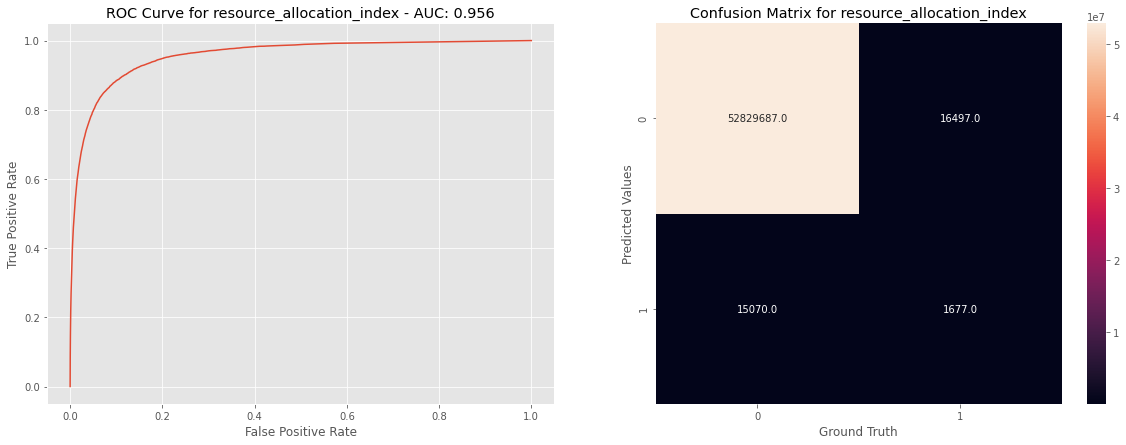

In [225]:
# Plot the ROC curve and Confusion Matrix

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(20)
sns.lineplot(x=fpr,y=tpr, ax=ax1,ci=None)
ax1.set_title("{0} {1} {2} {3}".format('ROC Curve for', chosen_heur.__name__, '- AUC:',str(auc)[:5]))
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
sns.heatmap(cm, ax=ax2,annot=True, fmt='0.1f')
ax2.set_title("{0} {1}".format('Confusion Matrix for', chosen_heur.__name__))
ax2.set_xlabel('Ground Truth')
ax2.set_ylabel('Predicted Values')
plt.show()